<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Logistic Regression
 
_Authors: Multiple_
 
---

<a id="learning-objectives"></a>
### Learning Objectives

By the end of this lesson, you will be able to..

- Explain how logistic regression modifies linear regression for classification problems.
- Interpret logistic regression coefficients.
- Build a logistic regression model.
- Calculate accuracy, true positive rate, and false negative rate from a confusion matrix.
- Explain the limitations of accuracy as a classification metric.
- Explain how to trade off true positive and false negative rate in a logistic regression model.

# Intro

Tonight we are talking about logistic regression, which despite its name is a classification algorithm.

**Exercise.**

/poll “Which of the following are classification (as opposed to regression) problems? (Select all that apply.)” “Predicting how many people will come to a meetup event.” “Predicting which of the people who signed up for a meetup will actually attend.” “Predicting the price that a house will sell for, based on its zip code and square footage.” “Assigning probabilities of experiencing a fire in the next six months to buildings in a city.” “Identifying animals in photographs by species.”

<a id="refresher-fitting-and-visualizing-a-linear-regression-using-scikit-learn"></a>
## Refresher: Fitting and Visualizing a Linear Regression Using scikit-learn
---

Use Pandas to load in the glass attribute data from the UCI machine learning website. The columns are different measurements of properties of glass that can be used to identify the glass type. For detailed information on the columns in this data set, [please see the included .names file](http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.names).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(font_scale=1.5);

In [2]:
glass_filepath = Path('.', 'data', 'glass.csv')
glass = pd.read_csv(glass_filepath)
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
# change columns to something more uniform
glass.columns = ['ri','na','mg','al','si','k','ca','ba','fe','glass_type']

**Data Dictionary**

- `Id`: number: 1 to 214
- `RI`: refractive index  
- `Na`: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- `Mg`: Magnesium
- `Al`: Aluminum
- `Si`: Silicon
- `K` : Potassium
- `Ca`: Calcium
- `Ba`: Barium
- `Fe`: Iron
- `Type` : Type of glass:

**Let's build a regression model for refractice index against aluminum content.**

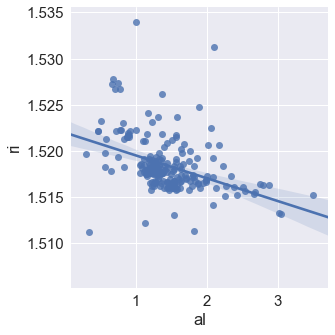

In [4]:
#scatter with regression line
sns.lmplot(data=glass, x='al', y='ri')

**Exercise.**

- Instantiate and fit a linear regression model predicting `ri` from `al` (and an intercept).

In [5]:
# Fit a linear regression model (name the model "linreg").

from sklearn.linear_model import LinearRegression

feature_cols = ['al']
X = glass.loc[:, feature_cols]
y = glass.loc[:, 'ri']

linreg = LinearRegression()
linreg.fit(X, y)




LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Add a column `y_pred` to `glass` that stores the model's fitted values for the refractice index.

In [6]:
# Make predictions for all values of X and add back to the original DataFrame.

glass.loc[:, 'predictions'] = linreg.predict(X)

- Plot the predicted `ri` against each `al` as a line.

In [7]:
# Plot those ri against al - connected by a line (try plt.plot()).

glass.plot(kind='line', x='al', y='prediction')

#plt.plot(glass.loc[:,'al'], glass.loc[:,'predictions'])

KeyError: 'prediction'

_Note the y axis labels when comparing to the scatterplot above._

- Plot this regression line with the scatter points on the same chart.

In [ ]:
# Put the plots together (use a scatter and line graph).
#use plt to plot bot the predicted line, and the scatter plot of al vs ri

plt.plot(glass.loc[:,'al'], glass.loc[:, 'predictions'], color='red')
plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'ri']);

- How good would you say that this model is, based on the graph? Suggestion: think about how it compares to a "null model" that just predicts the mean reflective index regardless of the aluminum content.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

null_pred = np.ones(y.shape)
null_pred *= y.mean()

null_rmse = (mean_squared_error(y, null_pred))**(0.5)
pred_rmse = (mean_squared_error(y, glass.loc[:, 'predictions']))**(0.5)

print(null_rmse)
print(pred_rmse)
print((pred_rmse - null_rmse) / null_rmse)

- Print out the intercept and coefficient values from our fit `LinearRegression` object.

In [ ]:
print(linreg.intercept_)
print(linreg.coef_)

- What do these numbers mean?

- Manually compute the predicted value of `ri` when `al=2.0` using the regression equation.

In [ ]:
# Compute prediction for al=2 using the equation.
1.52194533024 + 2*(-0.00247761)

- Confirm that this is the same value we would get when using the built-in `.predict()` method of the `LinearRegression` object.

In [ ]:
# Compute prediction for al=2 using the predict method.
linreg.predict(2)

---

<a id="predicting-a-categorical-response"></a>
## Predicting a Single Categorical Response
---

Linear regression is appropriate when we want to predict the value of a continuous target/response variable, but what about when we want to predict membership in a class or category?

**Examine the glass type column in the data set. What are the counts in each category?**

In [ ]:
# Examine glass_type.
glass.loc[:, 'glass_type'].value_counts()

Say these types are subdivisions of broader glass types:

> **Window glass:** types 1, 2, and 3

> **Household glass:** types 5, 6, and 7

**Create a new `household` column that indicates whether or not a row is household glass, coded as 1 or 0, respectively.**

In [ ]:
# Logistic Regression can only answer Yes/No Questions
# Types 1, 2, 3 are window glass.
# Types 5, 6, 7 are household glass.
# 1 for yes, 0 for no

glass.loc[:, 'household'] = glass.loc[:, 'glass_type'].map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.loc[:, 'household'].value_counts()

Let's change our task, so that we're predicting the `household` category using `al`. Let's visualize the relationship to figure out how to do this.

**Make a scatter plot comparing `al` and `household`.**

In [ ]:
plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'household'])
plt.xlabel('al')
plt.ylabel('household');

#we can see that there's higher 'al' in household glass

**Fit a new `LinearRegression` predicting `household` from `al`.**

Let's draw a regression line like we did before:

In [ ]:
# Fit a linear regression model and store the predictions.  
# SORT OF THE WRONG WAY OF DOING THIS

feature_cols = ['al']
X = glass.loc[:, feature_cols] 
y = glass.loc[:, 'household']

linreg = LinearRegression()
linreg.fit(X,y)

glass.loc[:, 'household_pred'] = linreg.predict(X)

In [ ]:
# Scatter plot that includes the regression line
plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'household'], alpha=.2)
plt.plot(glass.loc[:, 'al'], glass.loc[:, 'household_pred'], color='red')
plt.xlabel('al')
plt.ylabel('household')

If **al=3**, what class do we predict for household? **1**

If **al=1.5**, what class do we predict for household? **0**

We predict the 0 class for **lower** values of al, and the 1 class for **higher** values of al. What's our cutoff value? Around **al=2**, because that's where the linear regression line crosses the midpoint between predicting class 0 and class 1.

Therefore, we'll say that if **household_pred >= 0.5**, we predict a class of **1**, else we predict a class of **0**.

**Using this threshold, create a new column of our predictions for whether a row is household glass.**

In [ ]:
# np.where returns the first value if the condition is True,
# and the second value if the condition is False.

import numpy as np

nums = np.array([5, 15, 8])

np.where(nums > 10, 'BIG', 'small')



In [ ]:
# Transform household_pred to 1 or 0.
glass.loc[:, 'household_pred_class'] = np.where(glass.loc[:, 'household_pred']>= 0.5, 1, 0)
glass.tail()

**Plot a line that shows our predictions for class membership in household vs. not.**

In [ ]:
glass.sort_values('al', inplace=True)
plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'household'])
plt.xlabel('al')
plt.ylabel('household')

glass.sort_values('al', inplace=True)
plt.plot(glass.loc[:, 'al'], glass.loc[:, 'household_pred_class'], color='red')

Linear regression yields a reasonable binary classifier in this case when we map values above 0.5 to 1 and values below 0.5 to 0.

It would be nice if we could also interpret the raw numbers it gives us, e.g. as probabilities. The problem is that linear regression is unbounded. As a result, it gives values below 0 and above 1, which cannot be probabilities.

This is where logistic regression comes in: it basically takes that linear regression line and bends its ends into an S-shape so that it always stays between 0 and 1, so that we can interpret its outputs as probabilities.

<a id="using-logistic-regression-for-classification"></a>
## Using Logistic Regression for Classification
---

**Import the `LogisticRegression` class from `linear_model` below and fit the same regression model predicting `household` from `al`.**

In [ ]:
# Fit a logistic regression model and store the class predictions.

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

feature_cols = ['al']
X = glass.loc[:, feature_cols]
y = glass.loc[:, 'household']

logreg.fit(X,y)
glass.loc[:, 'household_pred_logreg'] = logreg.predict(X)

In [ ]:
glass.head()

**Plot the predicted class using the logistic regression as we did for the linear regression predictions above.**

As you can see, the class predictions are the same.

In [ ]:
# Plot the class predictions.
plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'household'])
plt.plot(glass.loc[:, 'al'], glass.loc[:, 'household_pred_logreg'], color='red')

What if we wanted the predicted probabilities instead of just the class predictions, to understand how confident we are in a given prediction?

**Using the built-in `.predict_proba()` function, examine the predicted probabilities for the first handful of rows of `X`.**

In [ ]:
# get probabilities using .predict_proba()
# returns 2 columns
# probability assigned to 0 vs 1
# windows vs household glass

logreg.predict_proba(X)

Sklearn orders the columns according to our class labels. The two-column output of `predict_proba` returns a column for each class of our `household` variable. The first column is the probability of `household=0` for a given row, and the second column is the probability of `household=1`.

**Store the predicted probabilities of class=1 in its own column in the data set.**

In [ ]:
# Store the predicted probabilities of class 1.

glass.loc[:, 'household_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
glass.head(10)

**Plot the predicted probabilities as a line on our plot (probability of `household=1` as `al` changes).**

In [ ]:
# Plot the predicted probabilities.  You get the nice S shape 

plt.scatter(glass.loc[:, 'al'], glass.loc[:, 'household'])
plt.plot(glass.loc[:, 'al'], glass.loc[:, 'household_pred_prob'], color='red')

In [ ]:
# Examine some example predictions.
print(logreg.predict_proba(1))

#89% that it's 0 = Window, not household

print(logreg.predict_proba(2))
print(logreg.predict_proba(3))

**Exercise**

- Build a logistic regression model for `household` using two features of your choice.
- Do a simple train-test split on `glass`.
- Train your model on the training set and evaluate it with `model.score` on the test set.

**Bonus**

Try out different sets of features to see which give the best results.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = ['na', 'mg']
X = glass.loc[:, feature_cols]
y = glass.loc[:, 'household']

X_train, X_test, y_train, y_test = train_test_split(X,y)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred_logpred_red_namg = logreg.predict(X_test)
#glass.loc[:, 'household_pred_logreg'] = logreg.predict(X)

In [ ]:
y_pred_logpred_red_namg

In [ ]:
#model score
print(metrics.accuracy_score(y_test, y_pred_logpred_red_namg))
print(logreg.score(X_test, y_test))

<a id="probability-odds-ratio-e-log-and-log-odds"></a>
## Understanding Logistic Regression
---

**Recall:** A coefficient in a *linear regression* model tells you how the *number* predicted by the model changes when the associated variable increases by one and all other variables remain the same.

**Similarly**, A coefficient in a *logistic regression* model tells you how the *log odds* predicted by the model changes when the associated variable increases by one and all other variables remain the same.

Let's try to develop some intuitions about log odds to help us reason about our logistic regression models.

#### Odds

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

It is often useful to think of the numeric odds as a ratio. For example, 5/1 = 5 odds is "5 to 1" -- five wins for every one loss (e.g. of six total plays). 2/3 odds means "2 to 3" -- two wins for every three losses (e.g. of five total plays).

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

**As an example we can create a table of probabilities vs. odds, as seen below.**

In [ ]:
# Create a table of probability versus odds.
table = pd.DataFrame({'probability':[0.1, 0.2, 0.25, 0.5, 0.6, 0.8, 0.9]})
table['odds'] = table.probability / (1 - table.probability)
table

**Exercise.**

Convert the following probabilities to odds:

1. .25
1. 1/3
1. 2/3
1. .95

In [ ]:
table = pd.DataFrame({'probability':[0.25, 1/3, 2/3, .95]})
table['odds'] = table.probability / (1 - table.probability)
table

<a id="understanding-e-and-the-natural-logarithm"></a>
### Understanding the Natural Logarithm

A logarithm tells you the *order of magnitude* of a number. The base-10 logarithm is a continuous version of "the number of times you would need to multiply 10 to get that number."

| number | number as a power of 10 | $\log_{10}$(number) |
| ------ | ----------------------------- |
| $1 $|$ 10^0$ | 0 |
| $10 $|$ 10^1$ | 1 |
| $100 $|$ 10^2$ | 2 |
| $1000 $|$ 10^3$ | 3 |

It also works in the other direction:

| number | number as a power of 10 | $\log_{10}$(number) |
| ------ | ----------------------------- |
| $.001 $ | $ 10^{-3}$ | -3 |
| $.01 $ | $ 10^{-2}$ | -2 |
| $.1 $|$ 10^{-1}$ | -1 |
| $1 $|$ 10^0$ | 0 |

And for numbers in between exact powers of 10:

| number | number as a power of 10 | $\log_{10}$(number) |
| ------ | ----------------------------- |
| $1$ | $ 10^{0}$ | 0 |
| $2$ | $ 10^{.301}$ | .301 |
| $5$|$ 10^{.699}$ | .699 |
| $10$|$ 10^1$ | 1 |
| $20$|$ 10^{1.301}$ | 1.301 |
| $50$|$ 10^{1.699}$ | 1.699 |
| $100$|$ 10^2$ | 2 |

**Base $e$.** It is often convenient to use the special number $e$ as a base instead of 10. The interpretation is analogous: the base-$e$ logarithm of a number is a continuous version of "the number of times you would have to multiple $e$ to get that number."

For instance:

| number | number as a power of $e$ | $\log_{e}$(number) |
| ------ | ----------------------------- |
| $1 $|$ e^0$ | 0 |
| $2.718$|$ e^1$ | 1 |
| $7.39$|$ e^2$ | 2 |
| $20.09$|$ e^3$ | 3 |

It also works in the other direction:

| number | number as a power of $e$ | $\log_{e}$(number) |
| ------ | ----------------------------- |
| $.050 $ | $ e^{-3}$ | -3 |
| $.135 $ | $ e^{-2}$ | -2 |
| $.368 $|$ e^{-1}$ | -1 |
| $1 $|$ e^0$ | 0 |

And for numbers in between exact powers of $e$:

| number | number as a power of $e$ | $\log_{e}$(number) |
| ------ | ----------------------------- |
| $1$ | $ e^{0}$ | 0 |
| $1.35$ | $ e^{.301}$ | .301 |
| $2.01$|$ e^{.699}$ | .699 |
| $2.718$|$ e^1$ | 1 |
| $3.67$|$ e^{1.301}$ | 1.301 |
| $5.47$|$ e^{1.699}$ | 1.699 |
| $7.39$|$ e^2$ | 2 |

When we take the **logarithm** of an **odds** we get the **log odds**.

The most common convention is to use base-$e$ logarithms unless otherwise specified.

In [ ]:
# Add log odds to the table.
table['logodds'] = np.log(table['odds'])
table

**Notice:** log odds goes to $-\infty$ as probability goes to 0, and goes to $\infty$ as probability goes to 1.

**Consequence:** The fact that linear model is unbounded is fine if we use it to model *log odds* rather than *probability*.

<a id="what-is-logistic-regression"></a>
### What Is Logistic Regression?
---

**Linear regression:** *Continuous response* is modeled as a linear combination of the features.

$$y = \beta_0 + \beta_1x$$

**Logistic regression:** *Log odds* is modeled as a linear combination of the features.

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x$$

This equation can be rearranged to get the predicted probability:

$$\hat{p} = \frac{e^{\beta_0 + \beta_1x}} {1 + e^{\beta_0 + \beta_1x}}$$

This equation gives us the "S" (sigmoid) shape for the predicted probability as a function of $\beta_1$.

### How do we interpret the regression parameters?

**Linear regression:**

$$y = \beta_0 + \beta_1x$$

- $\beta_0$ tells you the model's prediction for $y$ when all input features are zero.
- $\beta_1$ tells you how the model's prediction for $y$ changes with a one-unit increase in $x$ when all other variables remain the same.

**Logistic regression:**

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x$$

- $\beta_0$ tells you the model's prediction for the *log odds of $y$* when all input features are zero.
- $\beta_1$ tells you how the model's prediction for *the log odds of* $y$ changes with a one-unit increase in $x$ when all other variables remain the same.

-1.3149 coefficient on na means that predicted log odds that the glass is household decrease by 1.31, when na content increases by 1

**Bottom line:** A positive coefficient means that the predicted log odds of the response (and thus the predicted probability) increases with the associated variable, while a negative coefficient means that it decreases.

![Logistic regression beta values](./assets/logistic_betas.png)

Changing the $\beta_0$ value shifts the curve horizontally, whereas changing the $\beta_1$ value changes the slope of the curve.

### Summary

- Logistic regression addresses a binary classification problem by modeling the *log odds* that an individual is in the class as a linear function of the model features.
- A coefficient in a logistic regression model tells you *how the log odds that the model predicts changes* with a one-unit increase in the associated input feature, while other features remain unchanged.
- The model's log-odds predictions can be transformed into *probabilities*.
- Those predicted probabilities follow an "s" (sigmoid) shape that is bounded by 0 and 1, as a function of the input features.
- Those predicted probabilities can be converted into "hard" class predictions by mapping everything above a threshold to 1 and everything below it to 0.

<a id="comparing-logistic-regression-to-other-models"></a>
## Comparing Logistic Regression to Other Models
---

Advantages of logistic regression:

- Somewhat interpretable.
- Training and prediction are fast.
- Outputs probabilities.
- Features don't need scaling.
- Can perform well with a small number of observations.

Disadvantages of logistic regression:

- Presumes a linear relationship between the features and the log odds of the response.
- Performance is (generally) not competitive with the best supervised learning methods.
- Can't automatically learn feature interactions.

<a id="advanced-classification-metrics"></a>
## Advanced Classification Metrics

---

By default, the `.score` method of a logistic regression model in sklearn returns accuracy:

$$Accuracy = \frac{total~predicted~correct}{total~predicted}$$

However, accuracy is not always the most relevant metric.

Consider the **confusion matrix** for a binary classification problem where we have 165 observations/rows of people who are either smokers or nonsmokers.

<table style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"><font color="blue">TN = 50</font></td>
    <td style="text-align: center"><font color="red">FP = 10</font></td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"><font color="orange">FN = 5</font></td>
    <td style="text-align: center"><font color="green">TP = 100</font></td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>


- <font color="green">**True positives (TP):**</font> These are cases in which we predicted yes (smokers), and they actually are smokers.
- <font color="blue">**True negatives (TN):**</font> We predicted no, and they are nonsmokers.
- <font color="red">**False positives (FP):**</font> We predicted yes, but they were not actually smokers. (This is also known as a "Type I error.")
- <font color="orange">**False negatives (FN):**</font> We predicted no, but they are smokers. (This is also known as a "Type II error.")

**Exercise.**

Categorize these cases as TP, TN, FP, or FN.
    
- We predict that a growth is malignant, and it is benign. (is_malignant=1) - False Negative (False Positive)
- We predict that an image does not contain a cat, and it does not. (has_cat=1) True Negative
- We predict that a locomotive will fail in the next two weeks, and it does. (breaks=1)  True Positive
- We predict that a user will like a song, and she does not. (likes_song=1)  False Positive

<a id="accuracy-true-positive-rate-and-false-negative-rate"></a>
### Accuracy, True Positive Rate, and False Negative Rate

**Accuracy:** Overall, how often is the classifier correct?

<span>
    (<span style="color: green">TP</span>+<span style="color: blue">TN</span>)/<span style="color: purple">total</span> = (<span style="color: green">100</span>+<span style="color: blue">50</span>)/<span style="color: purple">165</span> = 0.91
</span>

<table style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom; color: purple">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center; background-color: blue">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center; background-color: green">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**True positive rate (TPR)** asks, “Out of all of the target class labels, how many were accurately predicted to belong to that class?”

For example, given a medical exam that tests for cancer, how often does it correctly identify patients with cancer?

<span>
<span style="color: green">TP</span>/<span style="color: aqua">actual yes</span> = <span style="color: green">100</span>/<span style="color: aqua">105</span> = 0.95
</span>

<table style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center;background-color: green">TP = 100</td>
    <td style="text-align: center;color: aqua">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**False positive rate (FPR)** asks, “Out of all items not belonging to a class label, how many were predicted as belonging to that target class label?”

For example, given a medical exam that tests for cancer, how often does it trigger a “false alarm” by incorrectly saying a patient has cancer?

<span>
<span style="color: orange">FP</span>/<span style="color: fuchsia">actual no</span> = <span style="color: orange">10</span>/<span style="color: fuchsia">60</span> = 0.17
</span>

<table style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center;background-color: orange">FP = 10</td>
    <td style="text-align: center;color:fuchsia">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**Exercise.**

You can tune your model to avoid Type 1 or Type 2 errors

We turn the probabilities output by a logistic regression model into "hard" predictions by setting a threshold. For instance, we might treat all probabilities above .5 as positive predictions and the rest as negative predictions.

- How does the true positive rate of a logistic regression model change if we change the threshold probability for treating a prediction as positive from .5 to .6?


answer:  Dec True Positive?


- How does the false positive rate of a logistic regression model change if we change the threshold probability for treating a prediction as positive from .5 to .6?



answer: Dec. False Positive

- Describe a situation in which you would want to use a high threshold probability.

- Describe a situation in which you would want to use a low threshold probability.

Answer:  Security Screening
Pregnancy

- Calculate the accuracy, true positive rate, and false positive rate for the confusion matrix below.

<table style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 140</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">30</td>
    <td style="text-align: center">10</td>
    <td style="text-align: center">40</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">60</td>
    <td style="text-align: center">40</td>
    <td style="text-align: center">100</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">90</td>
    <td style="text-align: center">50</td>
</tr>

</table>

Answer: 

accuracy = (30+40)/140 = 70/140 = .50

True Positive Rate = 40/100 = .40

False Positive Rate = 10/40 = .25


### Example

The true positive and false positive rates gives us a much clearer picture of where predictions begin to fall apart.

In [8]:
from sklearn import linear_model, metrics, model_selection

admissions_path = Path('.', 'data', 'admissions.csv')
admissions = pd.read_csv(admissions_path).dropna()
admissions.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


**We can predict the `admit` class from `gre` and use a train-test split to evaluate the performance of our model on a held-out test set.**

In [18]:
# Split data, train model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



feature_cols = ['gre']
X = admissions.loc[:, feature_cols]
y = admissions.loc[:, 'admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 46)
logit_simple = LogisticRegression()
logit_simple.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# Score model - our model gets it right 64% of the time
logit_simple.score(X_test, y_test)

0.64000000000000001

In [26]:
import numpy as np
# Compare to null model
# chose 0 zero because our null model says no everytime
# y.mean() - 32% people were admitted, so more likely NOT ADMITTED
y_pred_null = np.zeros(y_test.shape)
y_pred_null

# meaning - There's no predictive power to just saying No Everytime
metrics.accuracy_score(y_test, y_pred_null)

0.64000000000000001

In [32]:
# Get the confusion matrix
logit_pred_proba = logit_simple.predict_proba(X_test)[:, 1]
y_pred = logit_pred_proba > .5
metrics.confusion_matrix(y_test, y_pred)

array([[64,  0],
       [36,  0]])

**Exercise**

- What is our model doing?
- What is the model's accuracy on the test set?
- What is the model's true positive rate?
- What is the model's false positive rate?

Predicting No everytime

Accuracy: 64%

True Positive Rate: 0%

False Positive Rate: 0%

**We can vary the classification threshold for our model to get different predictions.**

In [33]:
y_pred = logit_pred_proba > .3

metrics.confusion_matrix(y_test, y_pred)

array([[25, 39],
       [ 9, 27]])

**Exercise**

- What is the model's accuracy on the test set?
- What is the model's true positive rate?
- What is the model's false positive rate?

Accuracy: 25+27/(100) = 52%

TPR: 27/(27+9) = 75%

FPR: 39/(39+25) = 61%

### Accuracy

**Advantages:**

- Intuitive: it's a lot like an exam score where you get total correct/total attempted.

**Disadvantages:**

- Potentially misleading: Can look OK when model is just outputting the most common label.
    - Particularly bad when classes are imbalanced -- e.g. train doesn't break 99% of the time, so a model that always says "won't break" has 99% accuracy -- but it fails exactly when we need it!
- Doesn't account for relative costs of false positives and false negatives.
- Doesn't say anything about how far predicted probabilities are from the correct labels.

**Other metrics to investigate:  All avail in scikitlearn**
    
- **Classification error:** Proportion of incorrect predictions (1-accuracy, lower is better).
- **Receiver Operating Characteristic (ROC) curves:** True positive rate vs. false positive rate across all possible threshold probabilities. The **area under the ROC curve** (AUC) is a measure of how well your model performs overall across those thresholds.
  - Allows you to visualize the performance of your classifier across all possible classification thresholds, thus helping you to choose a threshold that appropriately balances true positives and false positives.
  - Still useful when there is high class imbalance (unlike classification accuracy/error).
  - Harder to use when there are more than two response classes.
- **Log loss**: Measures how far the output probabilities are from the correct labels. (Useful when you want to make expected value calculations with those probabilities or triage cases for further attention.)
- **True Negative Rate**, **False Negative Rate**
- **Recall** (a.k.a. True Positive Rate), **Precision** (proportion of positive predictions that are true)

These measures are all readily available in sklearn.

## Lesson Review
- **Logistic regression**
  - What kind of machine learning problems does logistic regression address?
  - What do the coefficients in a logistic regression represent? How does the interpretation differ from ordinary least squares? How is it similar?
  
- **The confusion matrix**
  - Why isn't accuracy all you need to evaluate classification models?
  - How can you tune a model based on the relative costs of false positives and false negatives?

# Projects

- Final Project Pt 2 due today
- Final Project Pt 3 due Thurs.

# Questions?

```
=========================================
@channel
Exit Ticket: https://goo.gl/forms/OUw4gyTiRKMOTI3t2        

#feedback
=========================================
```

In [ ]:
#random sample of pandas dataframe in case you need to parse down the data

help(glass.sample)

In [128]:
#instarcart_data = instacart_data.sample(frac=.1)

In [ ]:
help(pd.read_csv)